In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/sizeNN_learnmodel_train/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/other_model/")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
                ]

In [ ]:
def short_predict(method_index,data,net,u_dim=1,Nstate=4):
    steps,train_traj_num,Nstates = data.shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = torch.DoubleTensor(data).to(device)
    X_current = net.encode(data[0,:,u_dim:]).T
    max_loss_list = []
    mean_loss_list = []
    min_loss_list = []
    pre_list = []
    real_list = []
    for i in range(steps-1):
        if method_index==4:
            X_current = net.forward(X_current.T,data[i,:,:u_dim]).T
        elif method_index==5:
            bilinear = net.bicode(X_current[:Nstate,:].T.detach(),data[i,:,:u_dim]).T #detach's problem 
            X_current = net.forward(X_current.T,bilinear.T).T
        elif method_index==6:
            bilinear = net.bicode(X_current[:Nstate,:].T.detach(),data[i,:,:u_dim]).T #detach's problem 
            X_current = net.forward(X_current.T,bilinear.T).T
        Y = data[i+1,:,u_dim:]
        Err = X_current[:Nstate,:].T-Y
        print(torch.mean(X_current[:Nstate,:].T,axis=0)[0],torch.mean(Y,axis=0)[0])
        # print(Y.shape)
        pre_list.append(np.array(torch.mean(X_current[:Nstate,:].T,axis=0).detach().cpu().numpy()))
        # print(torch.mean(X_current[:Nstate,:].T,axis=0).shape)
        real_list.append(np.array(torch.mean(Y,axis=0).detach().cpu().numpy()))
        max_loss_list.append(torch.mean(torch.max(torch.abs(Err),axis=0).values).detach().cpu().numpy())
        mean_loss_list.append(torch.mean(torch.mean(torch.abs(Err),axis=0)).detach().cpu().numpy())
        min_loss_list.append(torch.mean(torch.min(torch.abs(Err),axis=0).values).detach().cpu().numpy())
    print(np.array(pre_list)[:,0], np.array(real_list)[:,0])
    print(np.array(mean_loss_list))
    return np.array(max_loss_list),np.array(mean_loss_list),np.array(min_loss_list),np.array(pre_list),np.array(real_list)

In [ ]:
def mean_predict(suffix,env_name,method_index,layer_i,steps):
    # method_index = 0
    method = Methods[method_index]
    root_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+suffix
    print(method)
    #sys.path.append("control/train/")
    if  method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KoopmanNonlinear"):
        import learn_DKN_SOC_sizeNN as lka
    elif method.endswith("KoopmanNonlinearA"):
        import learn_DKAC_SOC_sizeNN as lka
    elif method.endswith("KoopmanU"):
        import learn_DKUC_SOC_sizeNN as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name+"layer{}".format(layer_i)+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = layer_i
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    #device = torch.device("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.cuda()
    net.double()
    Samples = 1
    steps = steps
    random.seed(2022)
    np.random.seed(2022)
    times = 5
    pre_list_all = np.zeros((times,steps,Nstates))
    rea_list_all = np.zeros((times,steps,Nstates))
    with torch.no_grad():
        for i in range(times):
            # test_data_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i)
            # if os.path.exists(test_data_path):
            #     test_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/{}{}.npy".format(env_name,i))
            # else:
            test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_short_predict_data/"+"method{}{}.npy".format(env_name,i),test_data)
            _,_,_,pre_list,rea_list = short_predict(method_index,test_data,net,udim,Nstate=Nstates)
            #print(pre_list.shape)
            pre_list_all = pre_list
            rea_list_all = rea_list
    pre_list_mean = pre_list_all#np.mean(pre_list_all,axis=0)
    rea_list_mean = rea_list_all#np.mean(rea_list_all,axis=0)  
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_short_predict_data/"+env_name+"_"+method+"layer1{}{}.npy".format(layer_i, steps),np.array([pre_list_mean, rea_list_mean]))
    np.save("6.2-pre.npy",pre_list_mean)
    np.save("6.2-real.npy",rea_list_mean)
    return pre_list_mean, rea_list_mean

In [ ]:
#suffix = "compare_DKAC_sizeNN_30"
#suffix = "DKUC_SOC_sizeNN"
#suffix = "DKN_SOC_sizeNN"
suffix = ["*","*","Knolinear_SOC_models","KRNN_SOC_models","DKUC_SOC_sizeNN","compare_DKAC_sizeNN_30","DKN_SOC_sizeNN"]
env_name = "DampingPendulum"
env_name = "MountainCarContinuous-v0"
# env_name = "CartPole-v1"
# env_name = "Pendulum-v1"
steps = 30
for i in range(6,7):
    pre_list_mean, rea_list_mean = mean_predict(suffix[i],env_name,method_index=i,layer_i=4,steps=steps)
    print(pre_list_mean.shape)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3
labels = ["*","*","BaseNet","KoopmanRNN","SDKN-DKUC","SDKN-DKAC","SDKN-DKN"]
plt.figure(figsize=(5, 3))
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = env_name
title = env_name
compare = "mean"
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
for i in range(1):
    pre_data = pre_list_mean
    real_data = rea_list_mean
    #print(data.shape)
    plt.plot(T,pre_data[:,0],'-',color = colors[i],label=labels[i])#np.log10(data)
    plt.plot(T,pre_data[:,1],'-',color = colors[i+2],label=labels[i])#np.log10(data)
    plt.plot(T,real_data[:,0],'--',color = colors[i+1],label=labels[i])#np.log10(data)
    plt.plot(T,real_data[:,1],'--',color = colors[i+3],label=labels[i])#np.log10(data)
    # plt.plot(T,pre_data[:,2],'-',color = colors[i],label=labels[i])#np.log10(data)
    # plt.plot(T,pre_data[:,3],'-',color = colors[i+2],label=labels[i])#np.log10(data)
    # plt.plot(T,real_data[:,2],'--',color = colors[i+1],label=labels[i])#np.log10(data)
    # plt.plot(T,real_data[:,3],'--',color = colors[i+3],label=labels[i])#np.log10(data)
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.xlabel("steps",fontsize=12)
plt.ylabel("state",fontsize=12)
# plt.ylim([-2,1])
# plt.yticks([])
plt.title(env_name,fontsize=12)
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/steps{}".format(steps)+env_name+"_models_"+compare+"_new1.png",dpi=500)

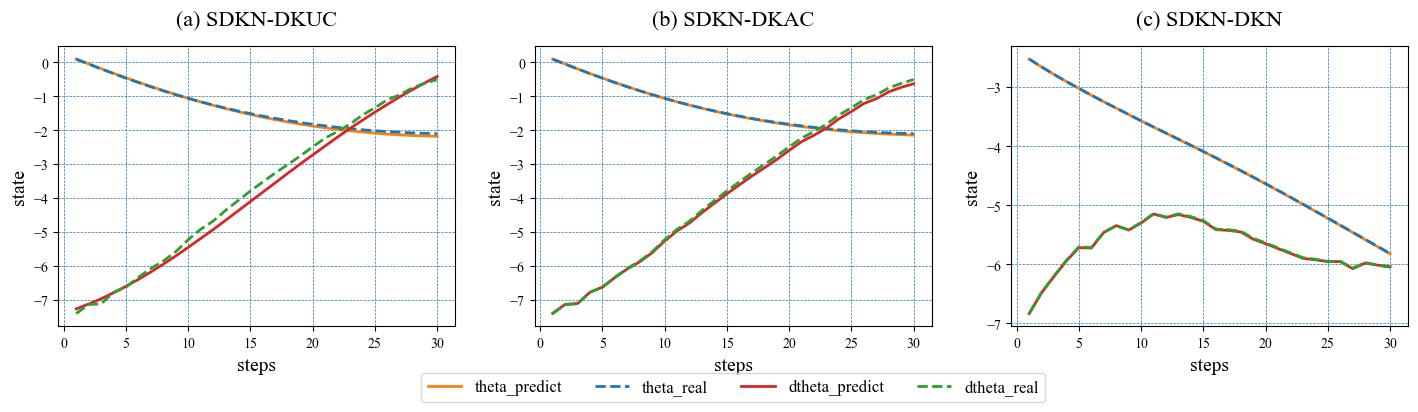

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.top'] = 0.9 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
T = []
steps = 30
for t in range(steps):
    T.append(t+1)
T = np.array(T)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.1-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.1-real.npy")
ax[0].plot(T,pre_data[:,0],'-', color = colors[1], label="theta_predict")
ax[0].plot(T,real_data[:,0],'--', color = colors[0], label="theta_real")
ax[0].plot(T,pre_data[:,1],'-', color = colors[3], label="dtheta_predict")
ax[0].plot(T,real_data[:,1],'--', color = colors[2], label="dtheta_real")
ax[0].set_xlabel("steps",fontsize=14)
ax[0].set_ylabel("state",fontsize=14)
#ax[0].set_yticks([])
ax[0].set_title("(a) SDKN-DKUC",fontsize=16)
ax[0].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.1-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.1-real.npy")
ax[1].plot(T,pre_data[:,0],'-', color = colors[1], label="theta_predict")
ax[1].plot(T,real_data[:,0],'--', color = colors[0], label="theta_real")
ax[1].plot(T,pre_data[:,1],'-', color = colors[3], label="dtheta_predict")
ax[1].plot(T,real_data[:,1],'--', color = colors[2], label="dtheta_real")
ax[1].set_xlabel("steps",fontsize=14)
ax[1].set_ylabel("state",fontsize=14)
#ax[1].set_yticks([])
ax[1].set_title("(b) SDKN-DKAC",fontsize=16)
ax[1].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.1-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.1-real.npy")
ax[2].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[2].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[2].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[2].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[2].set_xlabel("steps",fontsize=14)
ax[2].set_ylabel("state",fontsize=14)
#ax[2].set_yticks([])
ax[2].set_title("(c) SDKN-DKN",fontsize=16)
ax[2].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
#plt.suptitle("DampingPendulum",fontsize=16)#,x=0.5,y=0.7
plt.legend(bbox_to_anchor=(-0.7, -0.3), loc='lower center', ncol=4 ,fontsize=12)#bbox_to_anchor=(-0.7, -0.4),
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"dampingpendulum.png")
plt.show()

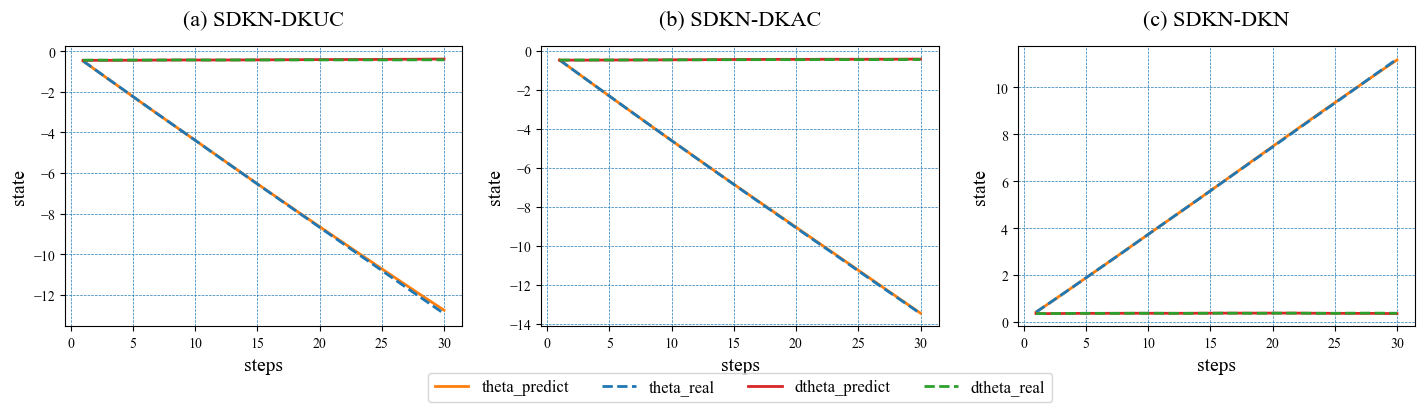

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.top'] = 0.9 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.2-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.2-real.npy")
ax[0].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[0].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[0].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[0].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[0].set_xlabel("steps",fontsize=14)
ax[0].set_ylabel("state",fontsize=14)
#ax[0].set_yticks([])
ax[0].set_title("(a) SDKN-DKUC",fontsize=16)
ax[0].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.2-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.2-real.npy")
ax[1].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[1].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[1].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[1].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[1].set_xlabel("steps",fontsize=14)
ax[1].set_ylabel("state",fontsize=14)
#ax[1].set_yticks([])
ax[1].set_title("(b) SDKN-DKAC",fontsize=16)
ax[1].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-real.npy")
ax[2].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[2].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[2].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[2].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[2].set_xlabel("steps",fontsize=14)
ax[2].set_ylabel("state",fontsize=14)
#ax[2].set_yticks([])
ax[2].set_title("(c) SDKN-DKN",fontsize=16)
ax[2].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
#plt.suptitle("DampingPendulum",fontsize=16)#,x=0.5,y=0.7
plt.legend(bbox_to_anchor=(-0.7, -0.3), loc='lower center', ncol=4 ,fontsize=12)#bbox_to_anchor=(-0.7, -0.4),
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"MountainCarContinuous.png")
plt.show()

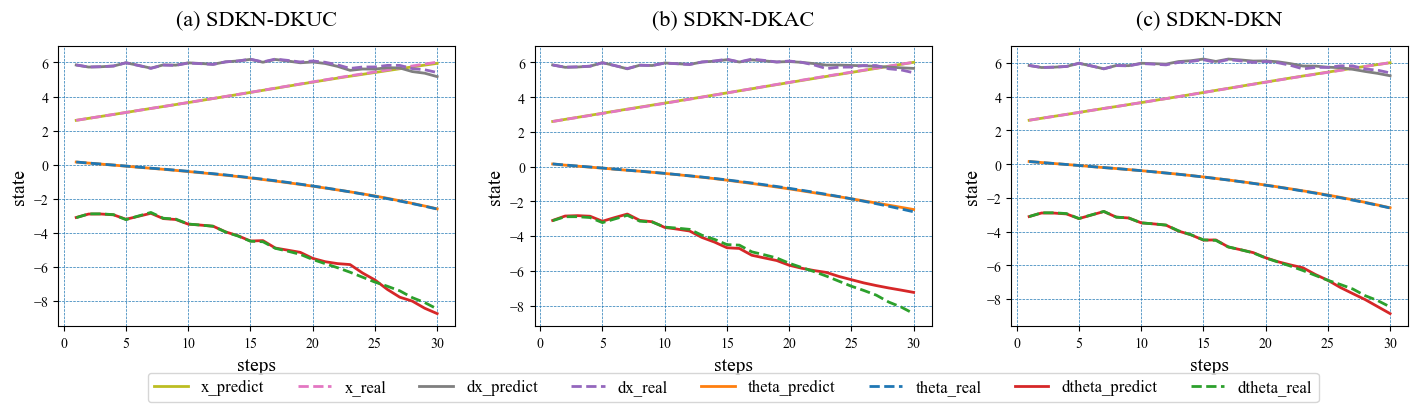

In [6]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.top'] = 0.9 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.3-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.3-real.npy")
ax[0].plot(T,pre_data[:30,0],'-', color = colors[8], label="x_predict")
ax[0].plot(T,real_data[:30,0],'--', color = colors[6], label="x_real")
ax[0].plot(T,pre_data[:30,1],'-', color = colors[7], label="dx_predict")
ax[0].plot(T,real_data[:30,1],'--', color = colors[4], label="dx_real")
ax[0].plot(T,pre_data[:30,2],'-', color = colors[1], label="theta_predict")
ax[0].plot(T,real_data[:30,2],'--', color = colors[0], label="theta_real")
ax[0].plot(T,pre_data[:30,3],'-', color = colors[3], label="dtheta_predict")
ax[0].plot(T,real_data[:30,3],'--', color = colors[2], label="dtheta_real")
ax[0].set_xlabel("steps",fontsize=14)
ax[0].set_ylabel("state",fontsize=14)
#ax[0].set_yticks([])
ax[0].set_title("(a) SDKN-DKUC",fontsize=16)
ax[0].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.3-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.3-real.npy")
ax[1].plot(T,pre_data[:30,0],'-', color = colors[8], label="x_predict")
ax[1].plot(T,real_data[:30,0],'--', color = colors[6], label="x_real")
ax[1].plot(T,pre_data[:30,1],'-', color = colors[7], label="dx_predict")
ax[1].plot(T,real_data[:30,1],'--', color = colors[4], label="dx_real")
ax[1].plot(T,pre_data[:30,2],'-', color = colors[1], label="theta_predict")
ax[1].plot(T,real_data[:30,2],'--', color = colors[0], label="theta_real")
ax[1].plot(T,pre_data[:30,3],'-', color = colors[3], label="dtheta_predict")
ax[1].plot(T,real_data[:30,3],'--', color = colors[2], label="dtheta_real")
ax[1].set_xlabel("steps",fontsize=14)
ax[1].set_ylabel("state",fontsize=14)
#ax[1].set_yticks([])
ax[1].set_title("(b) SDKN-DKAC",fontsize=16)
ax[1].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.3-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.3-real.npy")
ax[2].plot(T,pre_data[:30,0],'-', color = colors[8], label="x_predict")
ax[2].plot(T,real_data[:30,0],'--', color = colors[6], label="x_real")
ax[2].plot(T,pre_data[:30,1],'-', color = colors[7], label="dx_predict")
ax[2].plot(T,real_data[:30,1],'--', color = colors[4], label="dx_real")
ax[2].plot(T,pre_data[:30,2],'-', color = colors[1], label="theta_predict")
ax[2].plot(T,real_data[:30,2],'--', color = colors[0], label="theta_real")
ax[2].plot(T,pre_data[:30,3],'-', color = colors[3], label="dtheta_predict")
ax[2].plot(T,real_data[:30,3],'--', color = colors[2], label="dtheta_real")
ax[2].set_xlabel("steps",fontsize=14)
ax[2].set_ylabel("state",fontsize=14)
#ax[2].set_yticks([])
ax[2].set_title("(c) SDKN-DKN",fontsize=16)
ax[2].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
#plt.suptitle("DampingPendulum",fontsize=16)#,x=0.5,y=0.7
plt.legend(bbox_to_anchor=(-0.7, -0.3), loc='lower center', ncol=8 ,fontsize=12)#bbox_to_anchor=(-0.7, -0.4),
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"Cartpole.png")
plt.show()

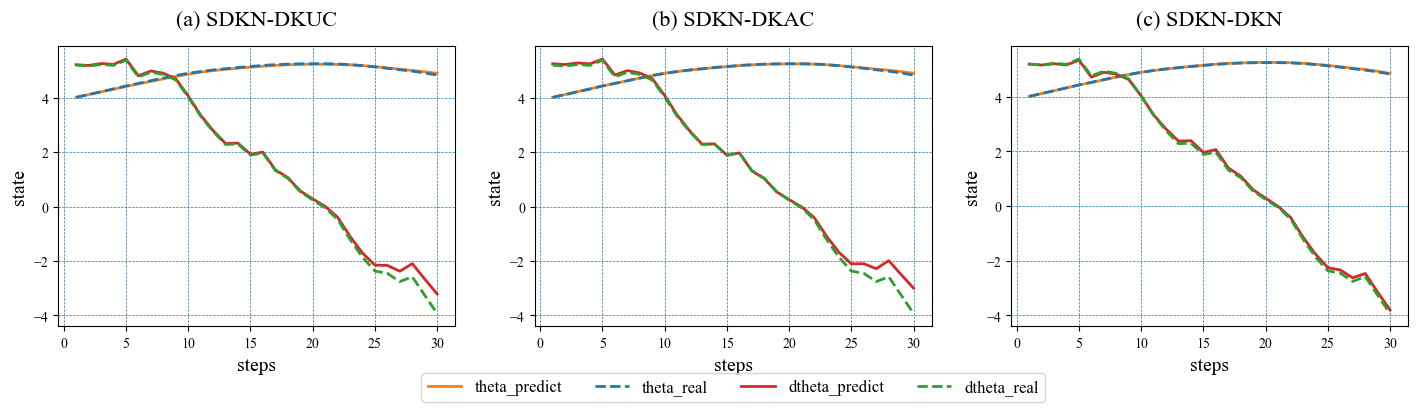

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.top'] = 0.9 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.4-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/4.4-real.npy")
ax[0].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[0].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[0].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[0].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[0].set_xlabel("steps",fontsize=14)
ax[0].set_ylabel("state",fontsize=14)
#ax[0].set_yticks([])
ax[0].set_title("(a) SDKN-DKUC",fontsize=16)
ax[0].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.4-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.4-real.npy")
ax[1].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[1].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[1].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[1].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[1].set_xlabel("steps",fontsize=14)
ax[1].set_ylabel("state",fontsize=14)
#ax[1].set_yticks([])
ax[1].set_title("(b) SDKN-DKAC",fontsize=16)
ax[1].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.4-pre.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.4-real.npy")
ax[2].plot(T,pre_data[:30,0],'-', color = colors[1], label="theta_predict")
ax[2].plot(T,real_data[:30,0],'--', color = colors[0], label="theta_real")
ax[2].plot(T,pre_data[:30,1],'-', color = colors[3], label="dtheta_predict")
ax[2].plot(T,real_data[:30,1],'--', color = colors[2], label="dtheta_real")
ax[2].set_xlabel("steps",fontsize=14)
ax[2].set_ylabel("state",fontsize=14)
#ax[2].set_yticks([])
ax[2].set_title("(c) SDKN-DKN",fontsize=16)
ax[2].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
#plt.suptitle("DampingPendulum",fontsize=16)#,x=0.5,y=0.7
plt.legend(bbox_to_anchor=(-0.7, -0.3), loc='lower center', ncol=4 ,fontsize=12)#bbox_to_anchor=(-0.7, -0.4),
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"Pendulum.png")
plt.show()

In [3]:
def short_predict_loss(method_index,data,net,u_dim=1,Nstate=4):
    steps,train_traj_num,Nstates = data.shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = torch.DoubleTensor(data).to(device)
    X_current = net.encode(data[0,:,u_dim:]).T
    max_loss_list = []
    mean_loss_list = []
    min_loss_list = []
    pre_list = []
    real_list = []
    for i in range(steps-1):
        if method_index==4:
            X_current = net.forward(X_current.T,data[i,:,:u_dim]).T
        elif method_index==5:
            bilinear = net.bicode(X_current[:Nstate,:].T.detach(),data[i,:,:u_dim]).T #detach's problem 
            X_current = net.forward(X_current.T,bilinear.T).T
        elif method_index==6:
            bilinear = net.bicode(X_current[:Nstate,:].T.detach(),data[i,:,:u_dim]).T #detach's problem 
            X_current = net.forward(X_current.T,bilinear.T).T
        Y = data[i+1,:,u_dim:]
        Err = X_current[:Nstate,:].T-Y
        # print(torch.mean(X_current[:Nstate,:].T,axis=0)[0],torch.mean(Y,axis=0)[0])
        # print(Y.shape)
        pre_list.append(np.array(torch.mean(X_current[:Nstate,:].T,axis=0).detach().cpu().numpy()))
        # print(torch.mean(X_current[:Nstate,:].T,axis=0).shape)
        real_list.append(np.array(torch.mean(Y,axis=0).detach().cpu().numpy()))
        max_loss_list.append(torch.mean(torch.max(torch.abs(Err),axis=0).values).detach().cpu().numpy())
        mean_loss_list.append(torch.min(torch.mean(torch.abs(Err),axis=0)).detach().cpu().numpy())
        min_loss_list.append(torch.mean(torch.min(torch.abs(Err),axis=0).values).detach().cpu().numpy())
    # print(np.array(pre_list)[:,0], np.array(real_list)[:,0])
    # print(np.array(mean_loss_list))
    return np.array(max_loss_list),np.array(mean_loss_list),np.array(min_loss_list),np.array(pre_list),np.array(real_list)

In [4]:
def mean_predict_loss(suffix,env_name,method_index,layer_i,steps):
    # method_index = 0
    method = Methods[method_index]
    root_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+suffix
    print(method)
    #sys.path.append("control/train/")
    if  method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KoopmanNonlinear"):
        import learn_DKN_SOC_sizeNN as lka
    elif method.endswith("KoopmanNonlinearA"):
        import learn_DKAC_SOC_sizeNN as lka
    elif method.endswith("KoopmanU"):
        import learn_DKUC_SOC_sizeNN as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name+"layer{}".format(layer_i)+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = layer_i
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    #device = torch.device("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.cuda()
    net.double()
    Samples = 5000
    steps = steps
    random.seed(2022)
    np.random.seed(2022)
    times = 1
    pre_list_all = np.zeros((times,steps,Nstates))
    rea_list_all = np.zeros((times,steps,Nstates))
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    min_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            # test_data_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i)
            # if os.path.exists(test_data_path):
            #     test_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/{}{}.npy".format(env_name,i))
            # else:
            test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_short_predict_data/"+"method{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss,min_loss,pre_list,rea_list = short_predict_loss(method_index,test_data,net,udim,Nstate=Nstates)
            #print(pre_list.shape)
            pre_list_all = pre_list
            rea_list_all = rea_list
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
            min_loss_all[i] = min_loss.reshape(-1)
    pre_list_mean = pre_list_all#np.mean(pre_list_all,axis=0)
    rea_list_mean = rea_list_all#np.mean(rea_list_all,axis=0)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    min_mean =  np.mean(min_loss_all,axis=0)
    min_std =  np.std(min_loss_all,axis=0)  
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_short_predict_data/"+env_name+"_"+method+"layer1{}{}.npy".format(layer_i, steps),np.array([pre_list_mean, rea_list_mean]))
    np.save("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_name+"_"+method+"{}.npy".format(steps),np.array([max_mean,max_std,mean_mean,mean_std,min_mean,min_std]))
    np.save("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/boxplot_value"+env_name+"_"+method+"{}.npy".format(steps),np.array([max_loss_all,mean_loss_all,min_loss_all]))
    return pre_list_mean, rea_list_mean

<>:80: DeprecationWarning: invalid escape sequence \P


In [9]:
#suffix = "compare_DKAC_sizeNN_30"
#suffix = "DKUC_SOC_sizeNN"
#suffix = "DKN_SOC_sizeNN"
suffix = ["*","*","Knolinear_SOC_models","KRNN_SOC_models","DKUC_SOC_sizeNN","compare_DKAC_sizeNN_30","DKN_SOC_sizeNN"]
env_name = "DampingPendulum"
# env_name = "MountainCarContinuous-v0"
# env_name = "CartPole-v1"
# env_name = "Pendulum-v1"
steps = 10000
for i in range(6,7):
    pre_list_mean, rea_list_mean = mean_predict_loss(suffix[i],env_name,method_index=i,layer_i=5,steps=steps)
method = Methods[i]

KoopmanNonlinearA


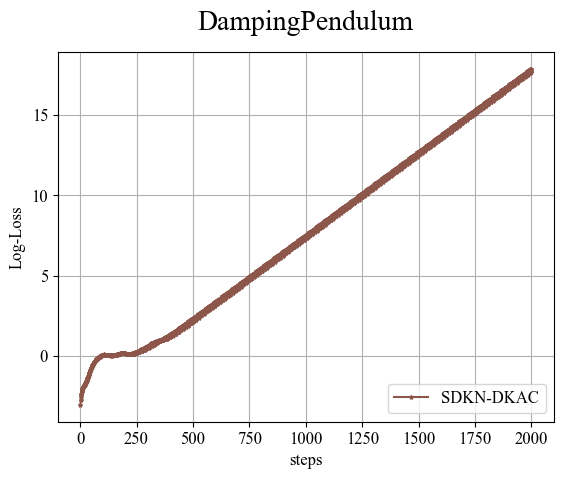

In [10]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3
labels = ["*","*","KDNN","KRNN","SDKN-DKUC","SDKN-DKAC","SDKN-DKN"]
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = env_name
title = env_name
compare = "mean"
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
for j in range(i,i+1):
    file_path = "D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_name+"_"+method+"{}.npy".format(steps)
    data = np.load(file_path)
    plt.plot(T,np.log10(data[2]),'*-',color = colors[j],label=labels[i])#,linewidth=1.5
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
plt.legend(loc = 'lower right')
plt.grid(True)
# plt.grid(linestyle='-.')
plt.xlabel("steps",fontsize=12)
plt.ylabel("Log-Loss",fontsize=12)
plt.title(title,fontsize=20)
#plt.savefig("D:/毕业设计/论文/pictures/SOC_sizeNN/SDKN-DKAC"+env_name+"_"+method+"_TESTmean_"+compare+"_new1.png",dpi=500)
plt.show()

In [ ]:
# import seaborn as sns
# a = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/boxplot_value"+env_name+"_"+method+"{}.npy".format(steps))
# print(a[1,:,:].shape)
# plt.boxplot(np.log10(a[2,:,:]))

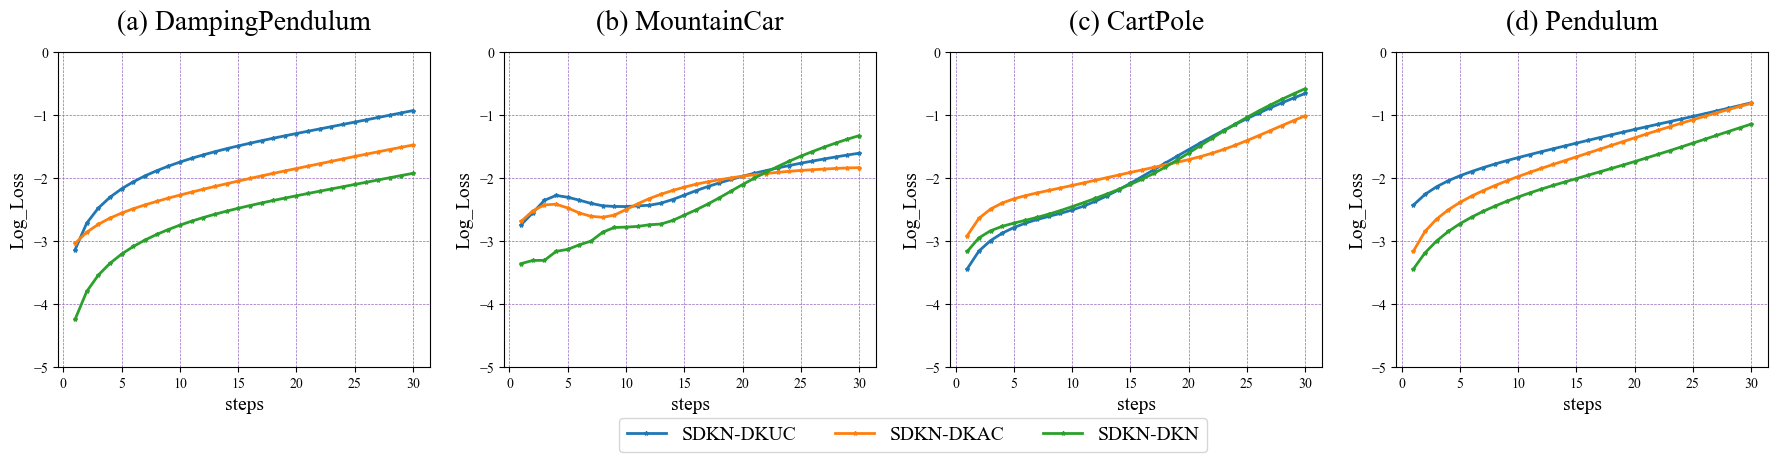

In [10]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.top'] = 0.9 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
pic_labels = ["SDKN-DKUC","SDKN-DKAC","SDKN-DKN"]
env_names = ["DampingPendulum","MountainCarContinuous-v0","CartPole-v1","Pendulum-v1"]
title_names = ["(a) DampingPendulum","(b) MountainCar","(c) CartPole","(d) Pendulum"]
piv_methods = ["KoopmanU","KoopmanNonlinearA","KoopmanNonlinear"]
steps = 30
grid_color = 4
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(19, 4.5))
i = 0
for j in range(len(piv_methods)):
    data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_names[i]+"_"+piv_methods[j]+"{}.npy".format(steps))
    ax[i].plot(T,np.log10(data[2]),'*-',color = colors[j],label=pic_labels[j])
ax[i].set_xlabel("steps",fontsize=14)
ax[i].set_ylabel("Log_Loss",fontsize=14)
ax[i].set_ylim([-5,0])
ax[i].grid(True, linestyle='--', color=colors[grid_color], linewidth=0.5)
ax[i].set_title(title_names[i],fontsize=20)
i = i + 1
for j in range(len(piv_methods)):
    data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_names[i]+"_"+piv_methods[j]+"{}.npy".format(steps))
    ax[i].plot(T,np.log10(data[2]),'*-',color = colors[j],label=pic_labels[j])
ax[i].set_xlabel("steps",fontsize=14)
ax[i].set_ylabel("Log_Loss",fontsize=14)
ax[i].set_ylim([-5,0])
ax[i].grid(True, linestyle='--', color=colors[grid_color], linewidth=0.5)
ax[i].set_title(title_names[i],fontsize=20)
i = i + 1
for j in range(len(piv_methods)):
    data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_names[i]+"_"+piv_methods[j]+"{}.npy".format(steps))
    ax[i].plot(T,np.log10(data[2]),'*-',color = colors[j],label=pic_labels[j])
ax[i].set_xlabel("steps",fontsize=14)
ax[i].set_ylabel("Log_Loss",fontsize=14)
ax[i].set_ylim([-5,0])
ax[i].grid(True, linestyle='--', color=colors[grid_color], linewidth=0.5)
ax[i].set_title(title_names[i],fontsize=20)
i = i + 1
for j in range(len(piv_methods)):
    data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_names[i]+"_"+piv_methods[j]+"{}.npy".format(steps))
    ax[i].plot(T,np.log10(data[2]),'*-',color = colors[j],label=pic_labels[j])
ax[i].set_xlabel("steps",fontsize=14)
ax[i].set_ylabel("Log_Loss",fontsize=14)
ax[i].set_ylim([-5,0])
ax[i].grid(True, linestyle='--', color=colors[grid_color], linewidth=0.5)
ax[i].set_title(title_names[i],fontsize=20)

plt.legend(bbox_to_anchor=(-1.3, -0.3), loc='lower center', ncol=3 ,fontsize=14)#bbox_to_anchor=(-0.7, -0.4),
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"all_loss.png")
plt.show()